<a href="https://colab.research.google.com/github/sachaRfd/openfabric-test/blob/main/RNN_Model_Training_Not_great_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installs and Imports:

!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np
import pandas as pd

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


# Import GloVe Vectors: 
from torchtext.vocab import GloVe

glove = GloVe(dim='50', name='6B', max_vectors=20000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 19999/20000 [00:01<00:00, 18486.11it/s]


In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
# import pandas as pd
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
# warnings.simplefilter("ignore")
print(torch.__version__)


1.13.1+cu116


Setting Up the dataset: 

In [ ]:
MAX_LEN = 200


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string 
from torch.nn.functional import pad 

def remove_numbers(txt):
    txt = ''.join(word for word in txt if not word.isdigit())
    return txt

def remove_punctuation(txt):
    
    for punctuation in string.punctuation:
        txt = txt.replace(punctuation, '') 
    
    return txt

def tokenize(txt):
    word_tokens = word_tokenize(txt) 
    return word_tokens

def remove_stopwords(word_tokens):
    stop_words = set(stopwords.words('english')) 
    word_tokens = [w for w in word_tokens if not w in stop_words] 
    return word_tokens


def get_index(txt, vocab=glove):
    embedded_text = []
    
    for word in txt:
        try:
            embedded_text.append(glove.stoi[word])
        except:
            pass
    
    return embedded_text

def pad_sentence(txt):
    if txt.shape[0]>=MAX_LEN:
        return txt[:MAX_LEN]
    else:
        return pad(txt, (0, MAX_LEN-txt.shape[0]), 'constant',0).long()
        

def transform_text(txt):
    txt = txt.lower()
    txt = remove_numbers(txt)
    txt = remove_punctuation(txt)
    txt = tokenize(txt)
    txt = remove_stopwords(txt)
    txt = torch.tensor(get_index(txt)).long()
    return pad_sentence(txt)

NameError: ignored

# Using RNN: 


In [ ]:
!pip install pycm livelossplot
%pylab inline

import random
import time
import math

import glob
import string
import unicodedata
import re
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.7/595.7 KB 15.7 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


No GPU available! Running on CPU
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# download the data
!mkdir data_gen
!cd data_gen && wget https://github.com/sachaRfd/ChatBot/blob/main/science_data.csv

--2023-02-15 16:38:41--  https://github.com/sachaRfd/ChatBot/blob/main/science_data.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘science_data.csv’

science_data.csv        [ <=>                ] 155.43K  --.-KB/s    in 0.07s   

2023-02-15 16:38:41 (2.09 MB/s) - ‘science_data.csv’ saved [159162]

--2023-02-15 16:38:42--  https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141847 (139K) [text/plain]
Saving to: ‘reddit-cleanjokes.csv’

reddit-cleanjokes.c 100%[===================>] 138.52K  --.-KB/s    

In [ ]:
pd.read_csv('data_gen/science_data.csv')


,ID,Question and Answer
0,1,What is the speed of light? The speed of light...
1,2,What is the formula for calculating force? The...
2,3,What is the difference between an atom and a m...
3,4,What is the process of photosynthesis? Photosy...
4,5,What is the theory of relativity? The theory o...
5,6,What is the structure of DNA? DNA is a double ...
6,7,What is a black hole? A black hole is a region...
7,8,What is the greenhouse effect? The greenhouse ...
8,9,What is the Big Bang theory? The Big Bang theo...
9,10,What is the difference between a hypothesis an...


In [ ]:
def readFile_csv(filename, header):
    """ 
    Read a csv file and return list with line entries 
    """
    dataframe = pd.read_csv(filename)
    data = dataframe[header].str.cat(sep=' ')
    data = data.split(' ')
    return data

filename, header = 'data_gen/science_data.csv', 'Question and Answer'
data = readFile_csv(filename, header)
print((data))
print(len(data))

['What', 'is', 'the', 'speed', 'of', 'light?', 'The', 'speed', 'of', 'light', 'is', 'approximately', '299,792,458', 'meters', 'per', 'second.', 'What', 'is', 'the', 'formula', 'for', 'calculating', 'force?', 'The', 'formula', 'for', 'calculating', 'force', 'is', 'force', '=', 'mass', 'x', 'acceleration.', 'What', 'is', 'the', 'difference', 'between', 'an', 'atom', 'and', 'a', 'molecule?', 'An', 'atom', 'is', 'the', 'smallest', 'unit', 'of', 'matter', 'that', 'retains', 'the', 'properties', 'of', 'an', 'element,', 'while', 'a', 'molecule', 'is', 'a', 'combination', 'of', 'two', 'or', 'more', 'atoms', 'held', 'together', 'by', 'covalent', 'bonds.', 'What', 'is', 'the', 'process', 'of', 'photosynthesis?', 'Photosynthesis', 'is', 'the', 'process', 'by', 'which', 'green', 'plants', 'and', 'some', 'other', 'organisms', 'use', 'sunlight', 'to', 'synthesize', 'foods', 'with', 'the', 'help', 'of', 'chlorophyll', 'and', 'other', 'pigments.', 'What', 'is', 'the', 'theory', 'of', 'relativity?', 'T

In [ ]:
word_counts = Counter(data)                                            # create a Counter for our data
uniq_words = sorted(word_counts, key=word_counts.get, reverse=True)    # find all unique words
print(uniq_words)                                                      # print the list of unique words
print(len(word_counts))                

['is', 'a', 'the', 'of', 'What', 'and', 'that', 'A', 'an', 'between', 'difference', 'while', 'or', 'in', 'to', 'The', 'for', 'chemical', 'can', 'as', 'substance', 'which', 'by', 'other', 'such', 'process', 'theory', 'black', 'reaction', 'An', 'up', 'heat', 'hypothesis', 'be', 'on', 'organism', 'its', 'through', 'star', 'formula', 'calculating', 'space', 'DNA', 'where', 'greenhouse', 'explanation', 'has', 'into', 'rock', 'subatomic', 'particle', 'supernova', 'change', 'physical', 'solute', 'force', 'atom', 'two', 'more', 'with', 'made', 'hole?', 'hole', 'region', 'gravitational', 'pull', 'so', 'strong', 'nothing,', 'light,', 'water', "Earth's", 'atmosphere', 'theory?', 'scientific', 'phenomenon', 'gene', 'smaller', 'than', 'bacteria', 'energy', 'involves', 'form', 'out', 'number', 'neutron', 'different', 'property', 'speed', 'light', '=', 'mass', 'unit', 'combination', 'photosynthesis?', 'Photosynthesis', 'some', 'organisms', 'structure', 'building', 'from', 'effect?', 'effect', 'certai

In [ ]:
word_to_index = {word: index for index, word in enumerate(uniq_words)} # create a word-to-index dictionary
index_to_word = {index: word for index, word in enumerate(uniq_words)} # create an index-to-word dictionary

words_indexes = [word_to_index[word] for word in data]                 # find the indices in all words in the dataset
print(words_indexes)      

[4, 0, 2, 88, 3, 160, 15, 88, 3, 89, 0, 161, 162, 163, 164, 165, 4, 0, 2, 39, 16, 40, 166, 15, 39, 16, 40, 55, 0, 55, 90, 91, 167, 168, 4, 0, 2, 10, 9, 8, 56, 5, 1, 169, 29, 56, 0, 2, 170, 92, 3, 171, 6, 172, 2, 173, 3, 8, 174, 11, 1, 175, 0, 1, 93, 3, 57, 12, 58, 176, 177, 178, 22, 179, 180, 4, 0, 2, 25, 3, 94, 95, 0, 2, 25, 22, 21, 181, 182, 5, 96, 23, 97, 183, 184, 14, 185, 186, 59, 2, 187, 3, 188, 5, 23, 189, 4, 0, 2, 26, 3, 190, 15, 26, 3, 191, 0, 1, 26, 6, 192, 2, 193, 9, 41, 5, 194, 5, 195, 196, 197, 198, 199, 4, 0, 2, 98, 3, 200, 42, 0, 1, 201, 202, 98, 60, 30, 3, 203, 21, 204, 2, 99, 205, 3, 206, 4, 0, 1, 27, 61, 7, 27, 62, 0, 1, 63, 13, 41, 43, 2, 64, 65, 0, 66, 67, 6, 68, 207, 69, 18, 208, 100, 209, 4, 0, 2, 44, 101, 15, 44, 102, 0, 1, 25, 22, 21, 103, 210, 24, 19, 104, 211, 5, 70, 105, 212, 31, 13, 2, 71, 72, 5, 213, 2, 214, 4, 0, 2, 106, 107, 73, 15, 106, 107, 26, 0, 1, 74, 45, 16, 2, 215, 3, 2, 216, 21, 217, 6, 2, 218, 219, 19, 1, 220, 5, 46, 108, 221, 222, 223, 4, 0, 2, 

In [ ]:
sequence_length= 4
index = 0
tensor_in = torch.tensor(words_indexes[index:index+sequence_length])
tensor_out = torch.tensor(words_indexes[index+1:index+sequence_length+1])

print(tensor_in)
print(tensor_out)

tensor([ 4,  0,  2, 88])
tensor([ 0,  2, 88,  3])


In [ ]:
class WordsTensorDataset(TensorDataset):
    def __init__(self, data_list, sequence_length=4):
        """
        Args:
            data_list (dictionary): A list of all the words in the file
            sequence_length: the number of words in each input sample, and output sample
        """
        self.sequence_length = sequence_length
        self.data_list = data_list
        self.unique_words = self.get_unique_words()

        self.word_to_idx = {word: idx for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of words to indices
        self.idx_to_word = {idx: word for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of indices to words     

        self.words_idxs = [self.word_to_idx[word] for word in data]                   # return a list of the dat with the words represented with their indices

    def get_unique_words(self):
        word_counts = Counter(self.data_list)
        return sorted(word_counts, key=word_counts.get, reverse=True)                 # return a list of the unique words sorted in ascending order

    def __len__(self):
        return len(self.words_idxs) - self.sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.words_idxs[idx:idx+self.sequence_length])       # get a sample input sequence
        sample_output = torch.tensor(self.words_idxs[idx+1:idx+self.sequence_length+1])  # get a sample output sequence

        return sample_input, sample_output

In [ ]:
words_dataset = WordsTensorDataset(data, sequence_length=5)
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)

next(iter(words_dataloader))

[tensor([[  4,   0,   2,  88,   3],
         [  0,   2,  88,   3, 160],
         [  2,  88,   3, 160,  15],
         [ 88,   3, 160,  15,  88],
         [  3, 160,  15,  88,   3]]), tensor([[  0,   2,  88,   3, 160],
         [  2,  88,   3, 160,  15],
         [ 88,   3, 160,  15,  88],
         [  3, 160,  15,  88,   3],
         [160,  15,  88,   3,  89]])]

In [ ]:
class RNNCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True, activation="tanh"):
        super(RNNCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # select appropriate activation function
        if activation == 'tanh':
            self.act = nn.Tanh()
        elif activation == 'ReLU':
            self.act = nn.ReLU()

        self.i2h = nn.Linear(input_size, hidden_size, bias=bias)    # create linear layer from input to hidden state
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)   # create linear layer from previous to current hidden state

        self.reset_parameters()                                     # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h):
        input = self.i2h(input)                                     # map from input to hidden state space
        h = self.h2h(h)                                             # map from previous to current hidden state space
        h = self.act(input + h)                                     # calculate new hidden state by applying activation

        return h

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False, activation='tanh'):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bias = bias

        self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers
        for l in range(self.num_layers):
            self.rnn_cell_list.append(RNNCell(self.input_size if l == 0 else self.hidden_size,
                                                self.hidden_size,
                                                self.bias,
                                                activation))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output
    
    def init_hidden(self,  batch_size=1):
        # initialise the hidden state
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device)

    def forward(self, input, h0):
        # Input of shape (batch_size, seqence length, input_size)
        # Output of shape (batch_size, output_size)

        outs = []
        hidden = []
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        batch_size = input.size(0)
        step_size = input.size(1)

        # iterate over all elements in the sequence
        for t in range(step_size):
            # iterate over each layer 
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer])

                # store the hidden state of each layer
                hidden[layer] = hidden_l

            # the hidden state of the last layer needs to be recorded
            # to be used in the output
            outs.append(hidden_l)

        # calculate output for each element in the sequence
        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out

In [ ]:
class RNN_GEN(nn.Module):

    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(RNN_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        
        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)                   # add a nn.Embedding
        self.rnn = RNN(self.input_size, self.hidden_size, self.num_layers, self.num_unique_words,  # add our RNN
                       bias=False, activation='tanh')

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.rnn.init_hidden(batch_size)      # initialise hidden state
        
        embedded = self.embedding(x)                   # store the word embeddings
        output = self.rnn(embedded, hidden)            # apply the RNN
        
        return output

def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

In [ ]:
def train_rnn_gen(model, optimizer, criterion, dataloader):
    model.train()    # set model to train mode
    train_loss = 0   # initialise the loss
    
    for i, (x, y) in enumerate(dataloader):  # loop over dataset
        
        x, y = x.to(device), y.to(device)    # send data to device
        optimizer.zero_grad()                # reset the gradients
        y_pred = model(x)                    # get output
        
        loss = criterion(y_pred.permute(0,2,1), y)  # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)
        train_loss += loss                   

        loss.backward()                      # backpropagate
        optimizer.step()                     # update weights

    return train_loss/len(dataloader)


def predict_rnn_gen(dataset, model, text, next_words=100):
    model.eval()  # set model to evaluation mode

    words = text.split(' ')

    for i in range(next_words):  # loop over words
        x = torch.tensor([[dataset.word_to_idx[word] for word in words[i:]]]).to(device)  # take word from dataset and send to device
        y_pred = model(x)                                                                 # compute output and hidden state
       
        last_word_logits = y_pred[0][-1]                                                  # take last output

        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()   # obtain probability vector for last output
        word_idx = np.random.choice(len(last_word_logits), p=p)                           # sample probability vector to get index in dataset 

        words.append(dataset.idx_to_word[word_idx])                                       # get word corresponding to dataset

    return ' '.join(words)

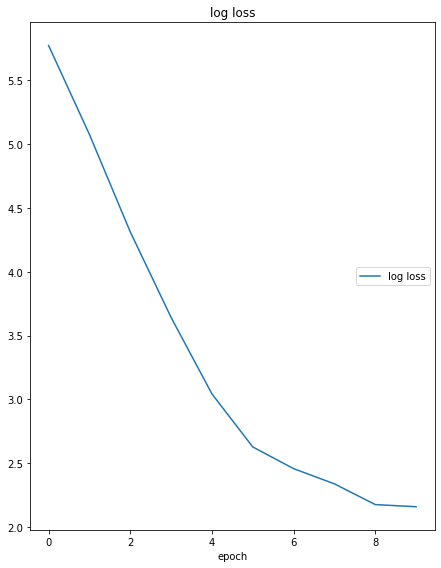

log loss
	log loss         	 (min:    2.159, max:    5.773, cur:    2.159)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 256
n_hidden = 256                         
n_layers = 2
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 5
sequence_length = 5

lr = 5e-3
momentum = 0.5
n_epochs = 10

rnn_gen = RNN_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(rnn_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)   

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_rnn_gen(rnn_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

In [ ]:
print(predict_rnn_gen(words_dataset, rnn_gen, text="What is the speed of force?", next_words=19))

What is the speed of force? The Bohr model is a model of a substance that can only be observed through a chemical reaction. What is a sedimentary rock? A sedimentary rock is a type of rock that is formed by the accumulation and cementation of sediment, such as sand, mud, or fossils. What is a
